In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../utils/")
sys.path.append(parent_dir)
from pathlib import Path
# from attention_visualisation import run_attention_dashboard, run_model_dashboard

## Results Visualisation

### Random Token Experiments

In [21]:
base_path = Path("experiments/training")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_1_3_{x}"
for exp in [0, 2, 5, 8]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['random_token'] = exp
    val_loss['random_token'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [22]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'random_token']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'random_token']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

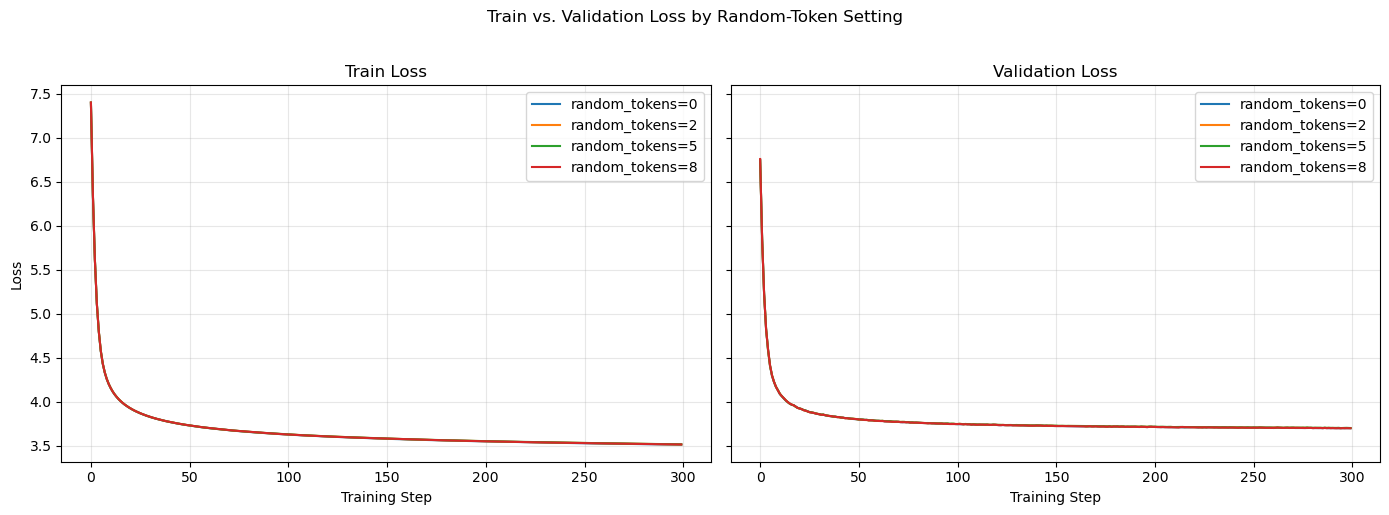

In [32]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['random_token'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'random_tokens={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Random-Token Setting', y=1.02)
plt.tight_layout()
plt.show()

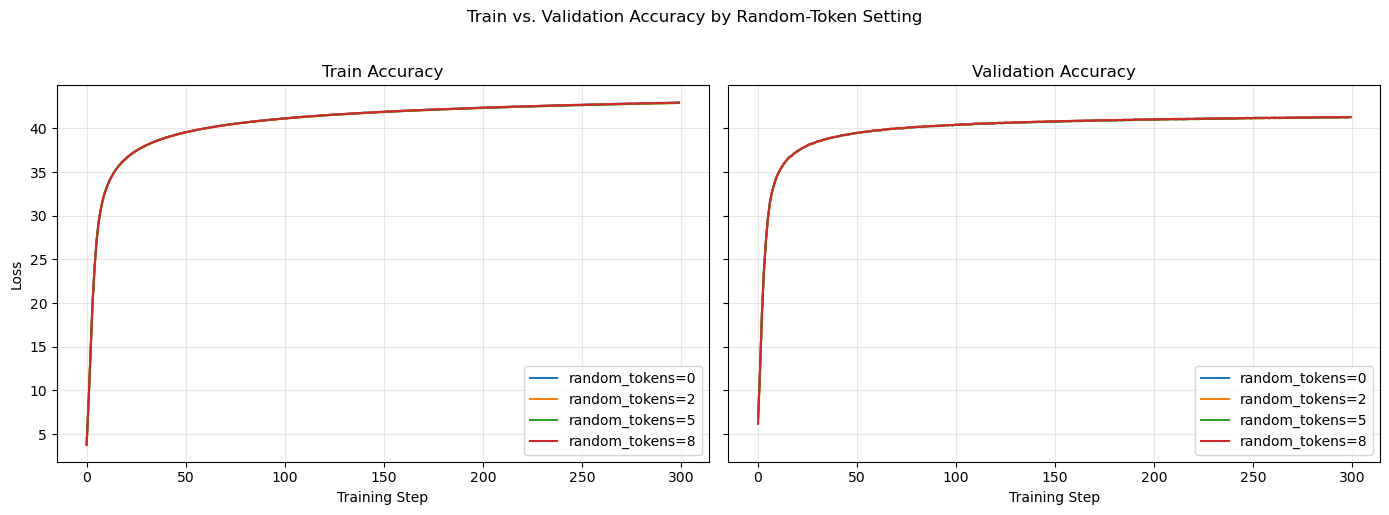

In [33]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['random_token'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by Random-Token Setting', y=1.02)
plt.tight_layout()
plt.show()


### Window Size Experiments

In [45]:
base_path = Path("experiments/training")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_1_{x}_5"
for exp in [3, 7, 9, 11, 5]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['window'] = exp
    val_loss['window'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [46]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'window']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'window']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

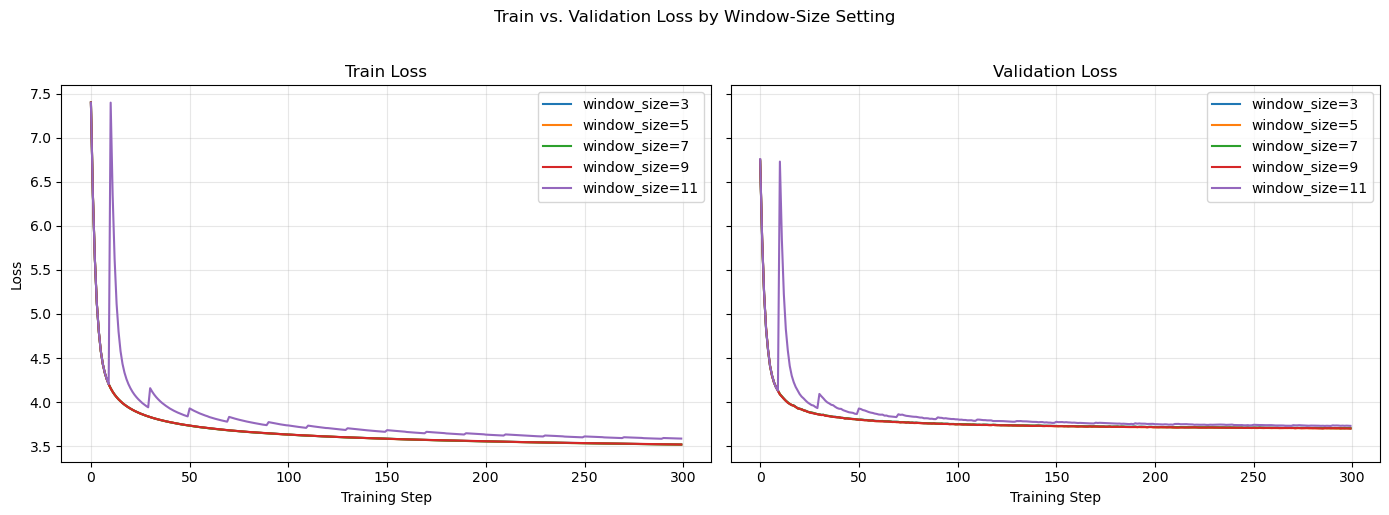

In [47]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['window'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['window'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['window'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Window-Size Setting', y=1.02)
plt.tight_layout()
plt.show()

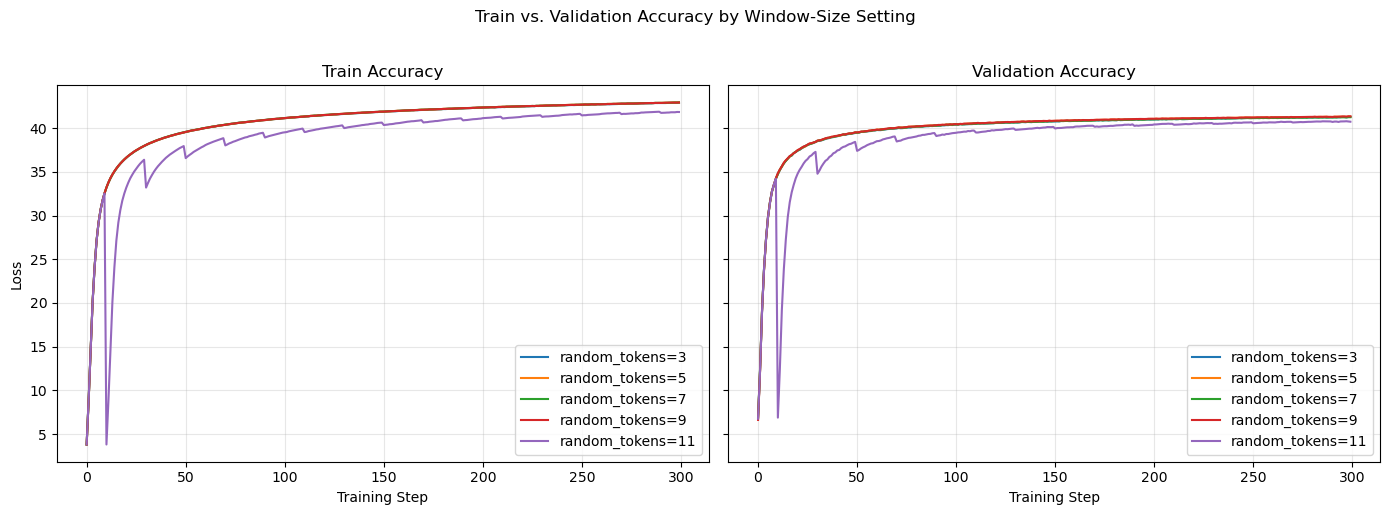

In [48]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['window'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['window'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['window'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by Window-Size Setting', y=1.02)
plt.tight_layout()
plt.show()


### Global Token Experiments

In [39]:
base_path = Path("experiments/training")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_{x}_3_5"
for exp in [0, 2, 4, 8, 16]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['global'] = exp
    val_loss['global'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [40]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'global']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'global']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

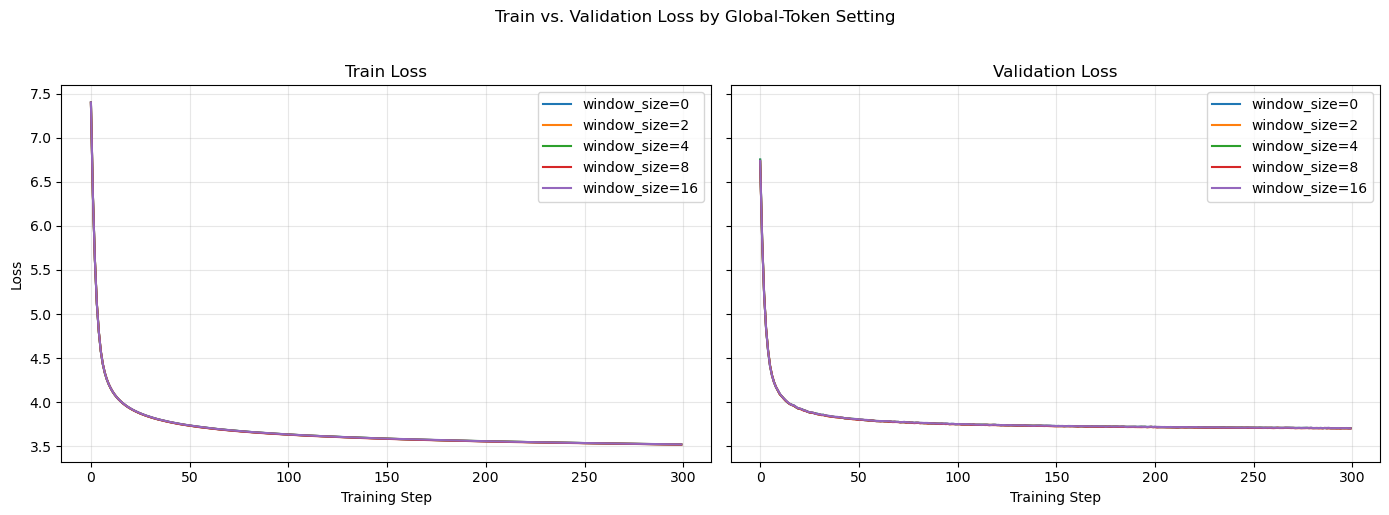

In [43]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['global'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['global'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['global'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Global-Token Setting', y=1.02)
plt.tight_layout()
plt.show()

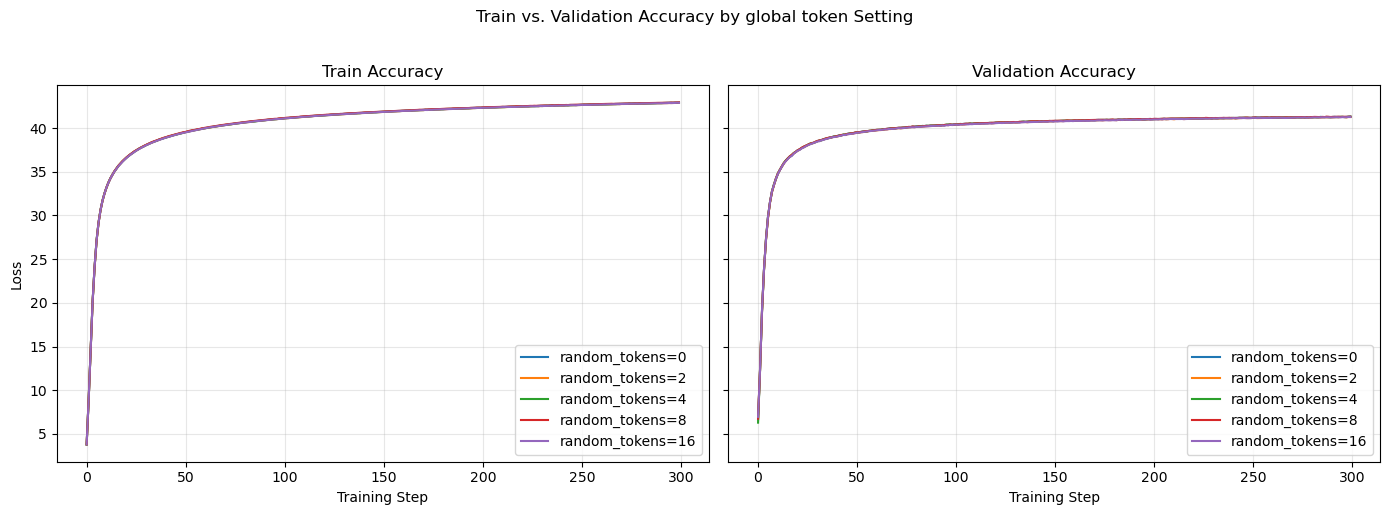

In [42]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['global'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['global'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['global'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by global token Setting', y=1.02)
plt.tight_layout()
plt.show()

### BLEU Scores

## Attention Visualisation

In [52]:
GA = 1
LA  = 3
RA = 5
D_MODEL = 256
N_HEADS = 16
N_ENCODERS = 2
N_DECODERS = 2
FF_HIDDEN = 2048

In [83]:
from papers.CommonTransformerComponents.train_sp import build_model, get_encodings, get_dataloaders, model_prediction

In [100]:
import sentencepiece as spm
mh = {
'D_MODEL': 256,
'N_HEADS': 16,
'N_ENCODERS': 2, # 6
'N_DECODERS': 2, # 6
'FF_HIDDEN': 2048,
'DROPOUT': 0.1,
'SEQ_LEN': 140,
'TRAIN_RATIO' : 0.99,
'BATCH_SIZE': 128,
'GLOBAL_ATTENTION': 1,
'LOCAL_ATTENTION': 3,
'RANDOM_ATTENTION': 5
}
sp = spm.SentencePieceProcessor(model_file="../attention_is_all_you_need/BPE/en-hi.model")
model  = build_model(sp, "cpu", mh, "sparse")

16 256 16 16
16 256 16 16
16 256 16 16
16 256 16 16
16 256 16 16
16 256 16 16


In [76]:
from collections import OrderedDict

checkpoint = torch.load(
    f"Models/"
    f"hindi_model_"
    f"{mh['N_HEADS']}_"
    f"{mh['D_MODEL']}_"
    f"{mh['FF_HIDDEN']}_"
    f"{mh['N_DECODERS']}_"
    f"{mh['N_ENCODERS']}_"
    f"{mh['GLOBAL_ATTENTION']}_"
    f"{mh['LOCAL_ATTENTION']}_"
    f"{mh['RANDOM_ATTENTION']}/"
    "Model_300",
    map_location=torch.device("cpu")
)

checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [80]:
import torch
import numpy as np

class AttentionScoreHook:
    def __init__(self, model):
        self.model = model
        self.attention_scores = []
        self.queries = []
        self.keys = []
        self.hook_handles = []
        self.layer_count = 0
        self._register_hooks()
        
    def _make_hook(self, layer_idx):
        def hook(module, input, output):
            if hasattr(module, 'attention_scores'):
                if module.queries is not None and module.keys is not None:
                    self.attention_scores.append((layer_idx, module.attention_scores.detach().cpu().clone()))
                    self.queries.append((layer_idx, module.queries.detach().cpu().clone()))
                    self.keys.append((layer_idx, module.keys.detach().cpu().clone()))
        return hook
    
    def _register_hooks(self):
        """Register hooks on all MultiHeadAttention modules"""
        layer_idx = 0
        for encoder_layer in self.model.encoder.layers:
            handle = encoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
        for decoder_layer in self.model.decoder.layers:
            # Self-attention
            handle = decoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
            # Cross-attention
            handle = decoder_layer.attention_2.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
    
    def get_attention_scores(self):
        """
        Get attention scores as [batch_size, num_layers, num_heads, seq_len, seq_len]
        
        Returns:
            Tuple of (attention_scores, queries, keys) each with shape 
            [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_scores
            and appropriate shapes for queries and keys
        """
        sorted_scores = sorted(self.attention_scores, key=lambda x: x[0])
        sorted_queries = sorted(self.queries, key=lambda x: x[0])
        sorted_keys = sorted(self.keys, key=lambda x: x[0])
        
        results = []
        for sorted_tensor in [sorted_scores, sorted_queries, sorted_keys]:
            tensors = [tensor for _, tensor in sorted_tensor]
            
            # Stack along a new dimension (layer dimension)
            stacked = torch.stack(tensors, dim=0)  # [num_layers, batch, heads, seq_len, seq_len/dk/dk]
            
            # Transpose to get [batch_size, num_layers, num_heads, seq_len, seq_len/dk/dk]
            transposed = stacked.permute(1, 0, 2, 3, 4)
            result = transposed.numpy()
            results.append(result)
        
        self.attention_scores = []
        self.keys = []
        self.queries = []
        
        return results[0], results[1], results[2]
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

def extract_attention_weights(model, src, tgt, src_masks=None, tgt_masks=None):
    """
    Extract attention weights from the model.
    
    Returns:
        Tuple of (attention_weights, queries, keys) each with shape 
        [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_weights
    """
    hook = AttentionScoreHook(model)    
    with torch.inference_mode():
        model(src, tgt, src_masks, tgt_masks, return_attention=True)
    
    attention_weights, queries, keys = hook.get_attention_scores()
    hook.remove_hooks()
    
    return attention_weights, queries, keys

def get_token_until_eos(tokens):
    if '<EOS>' in tokens:
        eos_idx = tokens.index('<EOS>')
        return tokens[: eos_idx + 1]
    else:
        return tokens

In [78]:
ee, he, sp = get_encodings("../../data/en-hi/", model_file="../attention_is_all_you_need/BPE/en-hi.model", nrows=100)
train_dataloader, test_dataloader = get_dataloaders(sp, ee, he, mh)


In [81]:
next(iter(train_dataloader))

{'src': tensor([[   1, 1630, 1300,  ...,    3,    3,    3],
         [   1, 2022, 7947,  ...,    3,    3,    3],
         [   1, 1138,  444,  ...,    3,    3,    3],
         ...,
         [   1,  172, 1733,  ...,    3,    3,    3],
         [   1,  172, 1889,  ...,    3,    3,    3],
         [   1,  172,  362,  ...,    3,    3,    3]]),
 'tgt': tensor([[   1,  131, 1190,  ...,    3,    3,    3],
         [   1, 3848,   94,  ...,    3,    3,    3],
         [   1,  965,  884,  ...,    3,    3,    3],
         ...,
         [   1,  125, 7916,  ...,    3,    3,    3],
         [   1, 1397,   56,  ...,    3,    3,    3],
         [   1, 5379, 1590,  ...,    3,    3,    3]]),
 'output': tensor([[ 131, 1190, 2218,  ...,    3,    3,    3],
         [3848,   94,  479,  ...,    3,    3,    3],
         [ 965,  884,   93,  ...,    3,    3,    3],
         ...,
         [ 125, 7916,  107,  ...,    3,    3,    3],
         [1397,   56, 1398,  ...,    3,    3,    3],
         [5379, 1590, 6594,  

In [94]:
batch['encoder_mask'].shape

torch.Size([99, 1, 1, 140])

In [96]:
batch = next(iter(train_dataloader))
# split_encoded = sp.id_to_piece(converted_sentence['src'][0].tolist())
# split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
# subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
# padding_mask = (pred != sp.pad_id()).int()
# decoder_mask = subsequent_mask & padding_mask
# attention_vals, query_vals, keys_vals = extract_attention_weights(model, converted_sentence['src'], pred, converted_sentence['encoder_mask'], decoder_mask.unsqueeze(0))
# split_encoded_trim = get_token_until_eos(split_encoded)
# split_decoded_trim = get_token_until_eos(split_decoded)

In [98]:
pred = model_prediction(model, batch, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())

torch.Size([99, 16, 140, 16])
torch.Size([99, 16, 140, 16])
torch.Size([99, 16, 140, 16])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [88]:
key = torch.randn(16, 140, 16, 16)
key.view(16, 140, 16, 1, 16).mean(dim=3).shape

torch.Size([16, 140, 16, 16])

In [89]:
split_encoded = sp.id_to_piece(batch['src'].tolist())
# split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
# subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
# padding_mask = (pred != sp.pad_id()).int()
# decoder_mask = subsequent_mask & padding_mask
# attention_vals, query_vals, keys_vals = extract_attention_weights(model, converted_sentence['src'], pred, converted_sentence['encoder_mask'], decoder_mask.unsqueeze(0))
# split_encoded_trim = get_token_until_eos(split_encoded)
# split_decoded_trim = get_token_until_eos(split_decoded)

TypeError: in method 'SentencePieceProcessor_IdToPiece', argument 2 of type 'int'